# Analysis of CRC PDO epithelial cells 

## Load packages and sc plotting settings

In [1]:
# Load packages
import scanpy as sc
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from copy import copy
import numpy as np
import anndata as ad
import meld
from scipy.stats import pearsonr
import gseapy

In [2]:
# Setup the global plotting parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = "viridis", frameon=True, transparent=True,
                    dpi_save=800, facecolor="None", format="pdf", figsize=[4,4])

sns.set_style("whitegrid", {'axes.grid' : False})

# Figure output directory
sc.settings.figdir = 'Fig_2/pdo_analysis/'

# Set seed for reproducibility
np.random.seed(0)

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


In [3]:
# Colour map
colour_dict_full = {'PDO_DMSO_PDO': '#c5d275', 
               'PDO_SN38_PDO': '#488f31', 
               'PDO_DMSO_PDO_CAF': '#BDDE6F', 
               'PDO_SN38_PDO_CAF':'#4D6417',
               'Fibroblast_DMSO_CAF': '#c3e7ff', 
               'Fibroblast_SN38_CAF': '#004c6d', 
               'Fibroblast_DMSO_PDO_CAF': '#FECEF1', 
               'Fibroblast_SN38_PDO_CAF' : '#D322A6'} 

colour_dict_sample = {'DMSO_PDO': '#8383FF', 
               'SN38_PDO': '#531B93',  
               'DMSO_PDO_CAF': '#E39097', 
               'SN38_PDO_CAF':'#941751', 
               'DMSO_CAF': '#C0C0C0', 
               'SN38_CAF': '#5E5E5E'}


colour_dict_cell_type = {'PDO': '#d4ac38', 
                         'Fibroblast': '#7c3b9e'} 

## Load processed anndata object

In [4]:
# Import data
input_file_path_rna = '../02_preprocessing_multimodal/ex0015_pdo_rna_adata.h5ad'  # h5ad file exported from preprocessing pipeline
input_file_path_adt = '../02_preprocessing_multimodal/ex0015_pdo_adt_adata.h5ad'  # h5ad file exported from preprocessing pipeline

signal_adata_rna = sc.read_h5ad(input_file_path_rna)
signal_adata_adt = sc.read_h5ad(input_file_path_adt)

# Inspect data shape
print(signal_adata_rna, ": data shape:", signal_adata_rna.shape)
print(signal_adata_adt, ": data shape:", signal_adata_adt.shape)

AnnData object with n_obs × n_vars = 30895 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances' : data shape: (30895, 33740)
AnnData object with n_obs × n_vars = 30895 × 21
    obs: 'n_genes_by_counts', 'log1p_n_g

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
signal_adata_rna.obs_names = signal_adata_rna.obs['barcode_seq'].astype('str') + '_' + signal_adata_rna.obs['sublib_index'].astype('str')

signal_adata_adt.obs['barcode_seq'] = signal_adata_adt.obs_names
signal_adata_rna.var_names =  signal_adata_rna.var_names.astype(str)
signal_adata_rna.var_names_make_unique()

raw_adata = signal_adata_rna.raw.to_adata()
raw_adata.var_names =  raw_adata.var_names.astype(str)
raw_adata.var_names_make_unique()
signal_adata_rna.raw = raw_adata

# Copy log-norm matrix to a new scaled layer
signal_adata_rna.layers['scaled'] = raw_adata.X.copy()

# Scaled data for plotting
sc.pp.scale(signal_adata_rna, max_value=10, layer='scaled')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [6]:
# Check if both obs_names arrays are equivalent
if np.array_equal(signal_adata_rna.obs_names, signal_adata_adt.obs_names):
    print("The arrays are equivalent.")
else:
    print("The arrays are not equivalent.")

The arrays are equivalent.


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **k

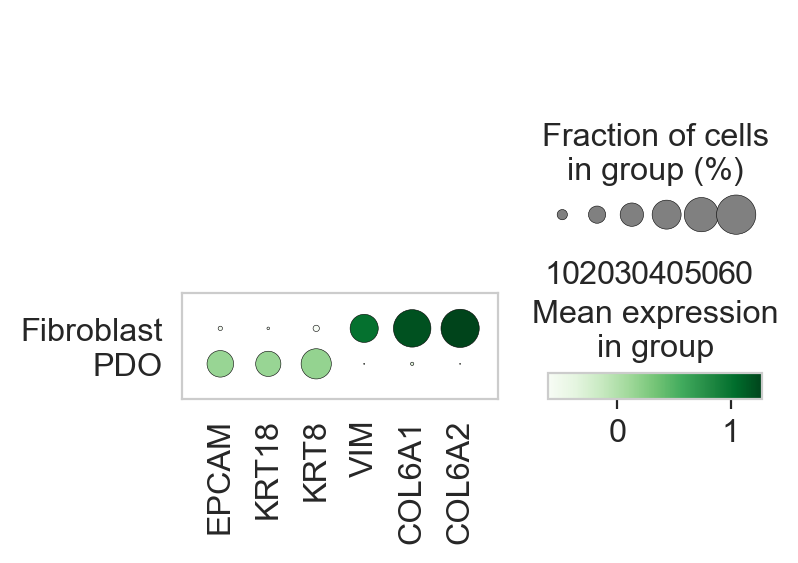

In [7]:
# CAF + PDO markers
cell_type_marker_genes = ['EPCAM', 'KRT18', 'KRT8', 'VIM', 'COL6A1', 'COL6A2']

sc.pl.dotplot(signal_adata_rna, groupby='cell_type', var_names=cell_type_marker_genes, 
              cmap='Greens', layer='scaled', save="_cell_type_markers") 

## PDO epithelial cell focused analysis

In [8]:
# Extract only CRC PDO epithelial cells
pdo_rna_adata =  signal_adata_rna[signal_adata_rna.obs['cell_type'].isin(['PDO'])]
pdo_adt_adata =  signal_adata_adt[signal_adata_adt.obs['cell_type'].isin(['PDO'])]

# Inspect data shape
print(pdo_rna_adata, ": data shape:", pdo_rna_adata.shape)
print(pdo_adt_adata, ": data shape:", pdo_adt_adata.shape)

View of AnnData object with n_obs × n_vars = 24197 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances' : data shape: (24197, 33740)
View of AnnData object with n_obs × n_vars = 24197 × 21
    obs: 'n_ge

In [9]:
# Run PHATE on PDO epithelial only
sc.external.tl.phate(pdo_rna_adata, t=12, random_state=12)

computing PHATE
Calculating PHATE...


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)


  Running PHATE on 24197 observations and 33740 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 187.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 132.29 seconds.
    Calculating affinities...
    Calculated affinities in 235.74 seconds.
  Calculated graph and diffusion operator in 556.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 38.62 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.44 seconds.
  Calculated landmark operator in 50.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.53 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.65 seconds.
Calculated PHATE in 660.81 seconds.


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/external/tl/_phate.py:152: ImplicitModificationWarning: Setting element `.obsm['X_phate']` of view, initializing view as actual.
  adata.obsm['X_phate'] = X_phate  # annotate samples with PHATE coordinates


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:15:01)


In [10]:
# Transfer PHATE embedding coordinates
pdo_adt_adata.obsm['rna_phate'] = pdo_rna_adata.obsm['X_phate']

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/1225728158.py:2: ImplicitModificationWarning: Setting element `.obsm['rna_phate']` of view, initializing view as actual.
  pdo_adt_adata.obsm['rna_phate'] = pdo_rna_adata.obsm['X_phate']


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

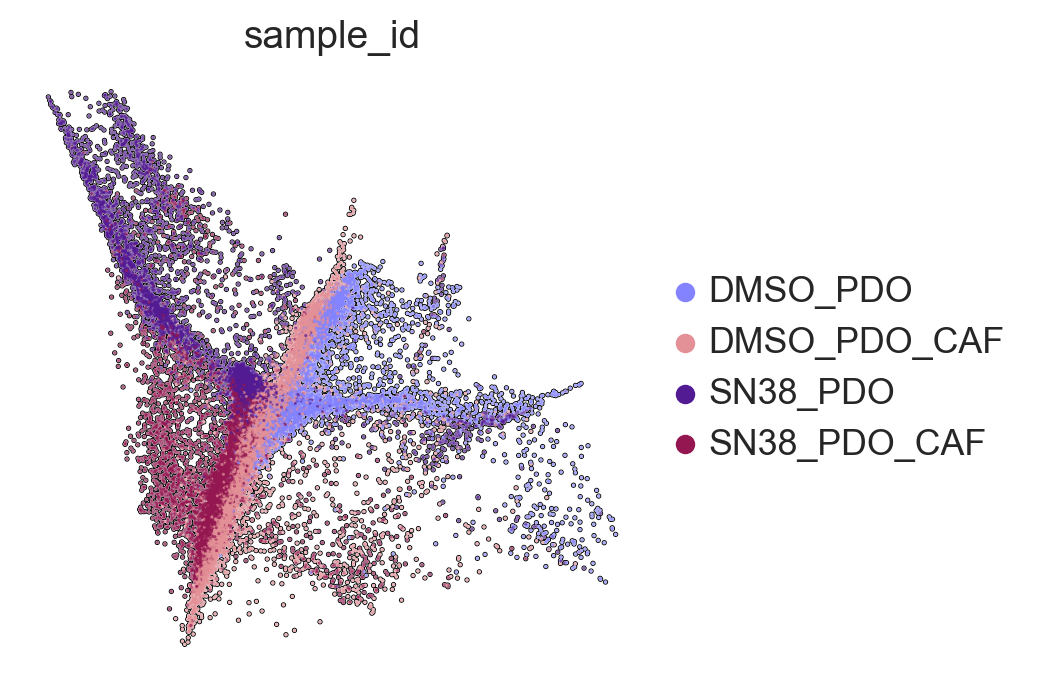

In [11]:
# PDO sample_ids
sc.external.pl.phate(pdo_rna_adata, color=['sample_id'],  
frameon=False, add_outline=True, palette=colour_dict_sample, save="_pdo_all_conds.pdf")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

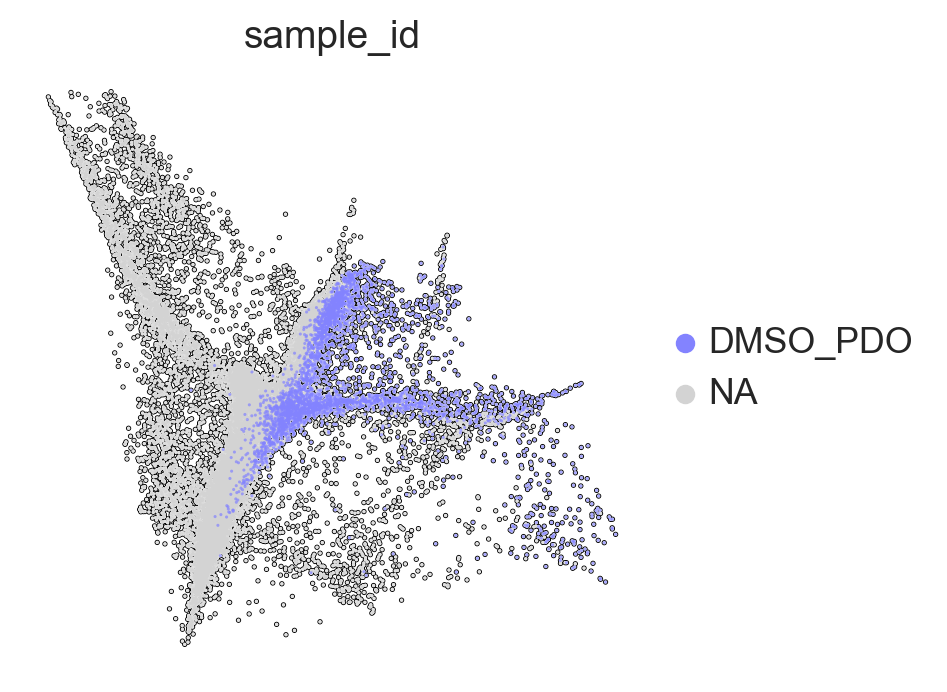

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

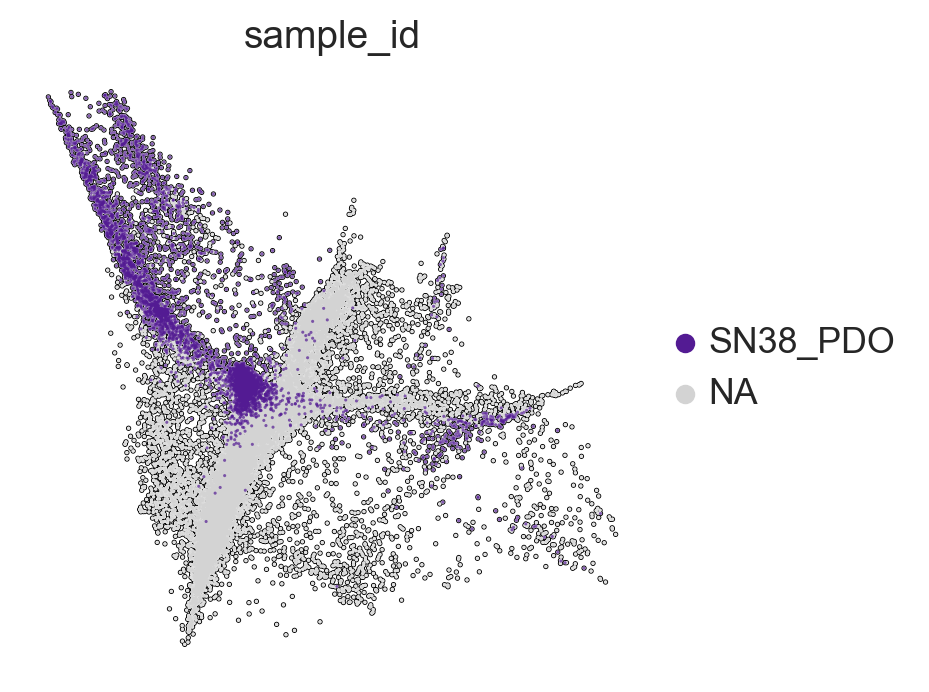

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

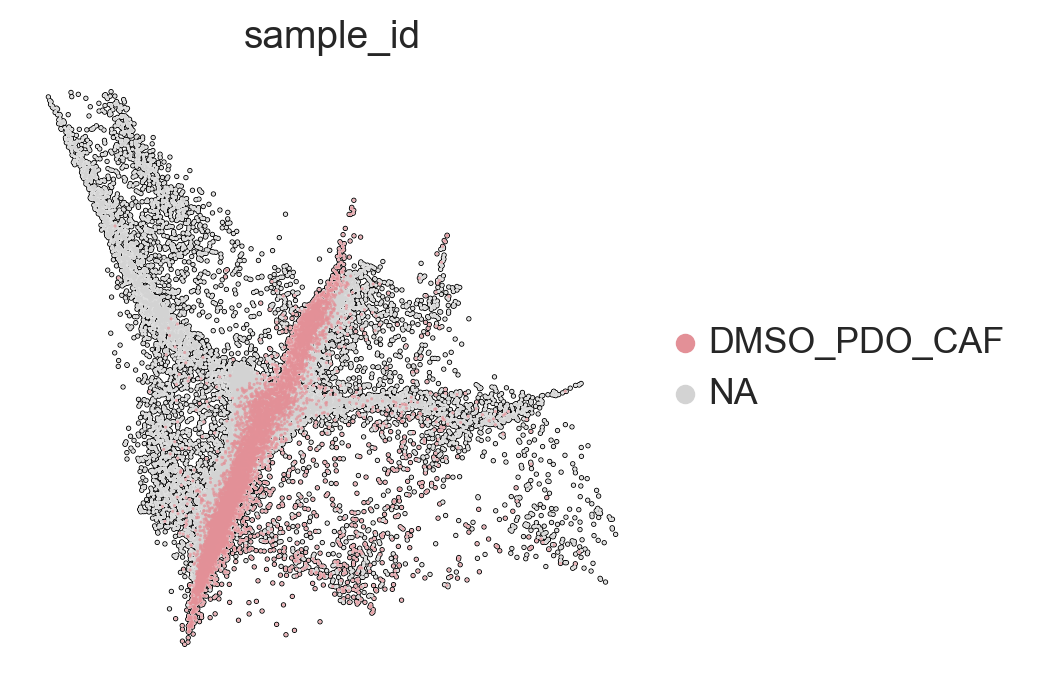

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

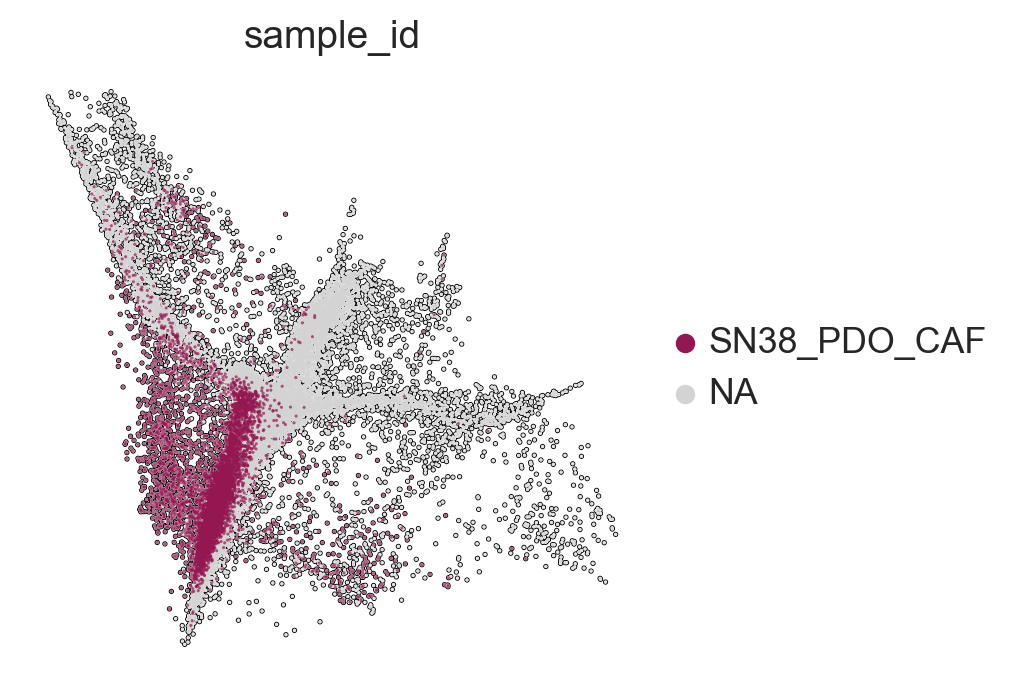

In [12]:
# View the sample_id RNA phate
sc.external.pl.phate(pdo_rna_adata, groups='DMSO_PDO', color=['sample_id'],
frameon=False, add_outline=True, palette=colour_dict_sample, save="_rna_dmso_pdo")

sc.external.pl.phate(pdo_rna_adata, groups='SN38_PDO', color=['sample_id'],
frameon=False, add_outline=True, palette=colour_dict_sample, save="_rna_sn38_pd")

sc.external.pl.phate(pdo_rna_adata, groups='DMSO_PDO_CAF', color=['sample_id'],
frameon=False, add_outline=True, palette=colour_dict_sample, save="_rna_dmso_cc")

sc.external.pl.phate(pdo_rna_adata, groups='SN38_PDO_CAF', color=['sample_id'],
frameon=False, add_outline=True, palette=colour_dict_sample, save="_rna_sn38_cc")

## DNA damage response

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


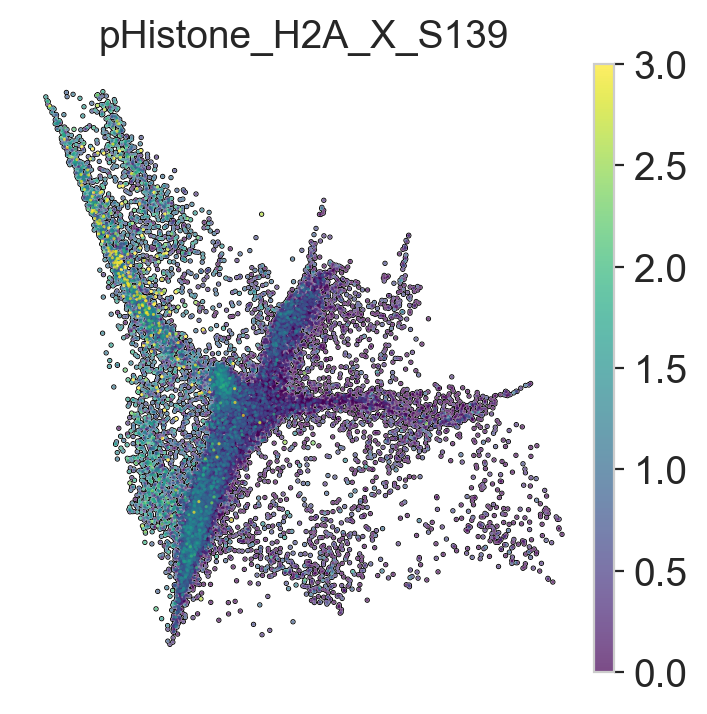

In [13]:
# ADTs on RNA PHATE
sc.pl.embedding(pdo_adt_adata, basis='rna_phate', color=['pHistone_H2A_X_S139'],
frameon=False, add_outline=True,  vmin=0, vmax=3, color_map='viridis', save="_adt_h2ax")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


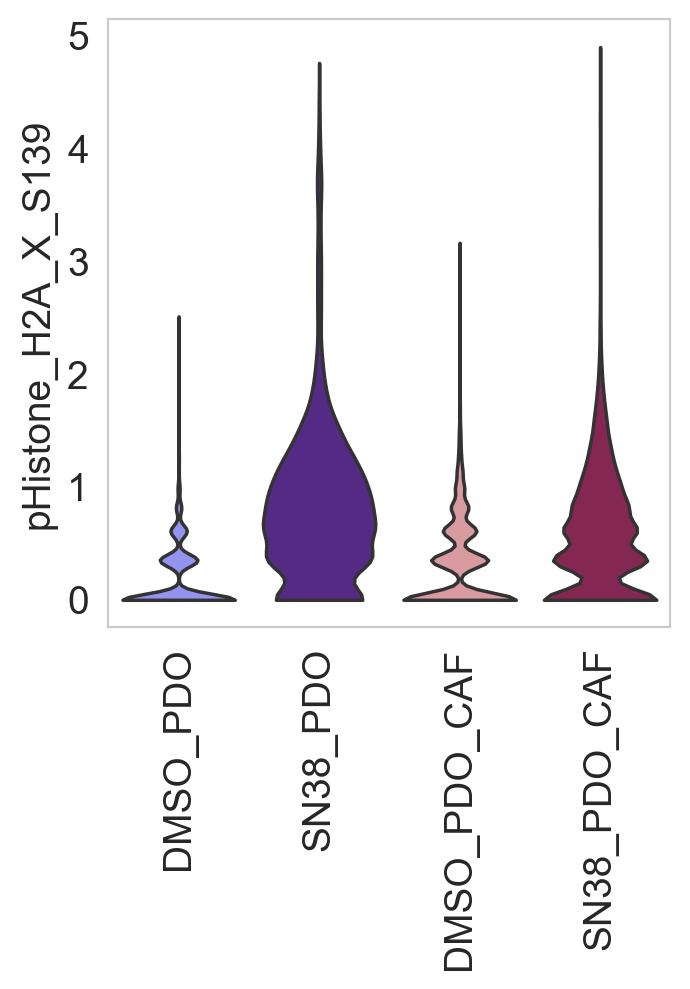

In [14]:
vl_order = ['DMSO_PDO', 'SN38_PDO', 'DMSO_PDO_CAF', 'SN38_PDO_CAF']

# Gamma H2AX voilin
sc.pl.violin(pdo_adt_adata, ['pHistone_H2A_X_S139'],
             stripplot=False, palette=colour_dict_sample, groupby='sample_id', log=False, rotation=90,
             order = vl_order, save="_gamma_h2ax")

In [15]:
# Create a barplot for the proportion of S-phase cells
phase_data_df = sc.get.obs_df(
    pdo_rna_adata,
    keys=['sample_id', 'phase']
)

# Calculate the total count of observations per condition and replicate
total_counts = phase_data_df.groupby(['sample_id']).size().reset_index(name='total_count')

# Calculate the count of observations per condition, replicate, and cell cycle score category
category_counts = phase_data_df.groupby(['sample_id', 'phase']).size().reset_index(name='category_count')

# Merge the total counts and category counts dataframes
merged_df = pd.merge(category_counts, total_counts, on=['sample_id'])


# Calculate the proportion by dividing the category count by the total count
merged_df['proportion'] = merged_df['category_count'] / merged_df['total_count']

# Split by phase
phase_data_df_S = merged_df[merged_df['phase'] == 'S']
phase_data_df_G2M = merged_df[merged_df['phase'] == 'G2M']
merged_df

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/2496225516.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = phase_data_df.groupby(['sample_id']).size().reset_index(name='total_count')
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/2496225516.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = phase_data_df.groupby(['sample_id', 'phase']).size().reset_index(name='category_count')


,sample_id,phase,category_count,total_count,proportion
0,DMSO_PDO,G1,1052,3650,0.288219
1,DMSO_PDO,G2M,1217,3650,0.333425
2,DMSO_PDO,S,1381,3650,0.378356
3,DMSO_PDO_CAF,G1,3648,8835,0.412903
4,DMSO_PDO_CAF,G2M,2957,8835,0.334692
5,DMSO_PDO_CAF,S,2230,8835,0.252405
6,SN38_PDO,G1,2441,5045,0.483845
7,SN38_PDO,G2M,1186,5045,0.235084
8,SN38_PDO,S,1418,5045,0.281070
9,SN38_PDO_CAF,G1,3768,6667,0.565172


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/4287431976.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.catplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/

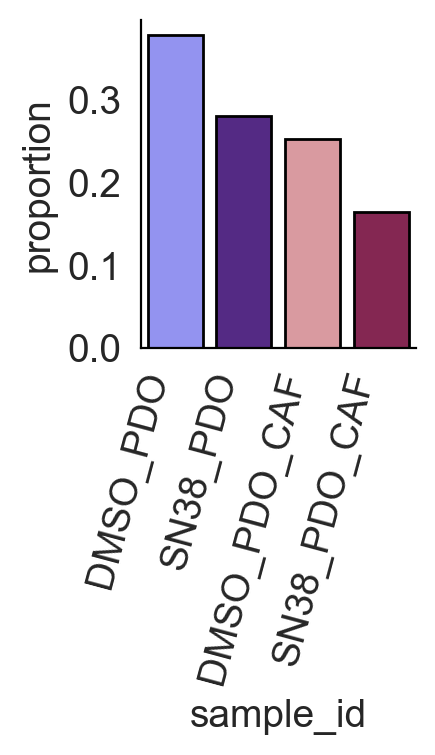

In [16]:
# Plot S bar
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.edgecolor': 'black'})


chart = sns.catplot(
    data=phase_data_df_S, x="sample_id", y="proportion",
    kind="bar", height=4, aspect=.6,
    edgecolor="black",
    palette=colour_dict_sample,
    order=vl_order
)

plt.xticks(rotation=75, ha='right')

#Save the plot
plt.tight_layout()
plt.savefig("s_phase_bar_pdo.pdf")

# Show the plot
plt.show()

In [17]:
# Recover raw data for correlation
marker_genes = pdo_rna_adata.var_names
ln_rna_data  = pdo_rna_adata.raw.to_adata()
ln_rna_data.obs = pdo_rna_adata.obs

# Get function
ln_mrna_data = sc.get.obs_df(
    ln_rna_data,
    keys=[*marker_genes]
)

ln_mrna_data

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSG00000291273,ENSG00000291274,ENSG00000291276,COL6A4P1-1,ENSG00000291283,ENSG00000291293,ENSG00000291297,ENSG00000291299,TMEM276-ZFTRAF1,TMEM276
AAACATCGAACAACCAAAACGATA_76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.108501,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACATCGAACCGAGAGGGATCGG_76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACATCGACACGACCGACCTTTC_76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACATCGACAGATTCCGCGACTA_76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACATCGACAGCAGACGCCCGGA_76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.760777,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCATGAAGAGAGTGCTAGC_79,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTCACGCATGGAACAAGCCGTGTA_79,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTCACGCATGGCTTCACACAATTG_79,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,1.623668,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTCACGCATGGTGGTATTGGGAGA_79,1.218325,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.218325,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Correlate gH2AX across all samples

In [18]:
# Generate ADT df for correlation 
pdo_adt_df = pdo_adt_adata.to_df()

In [19]:
def calculate_pearson(column):
    correlation, p_value = pearsonr(column, pdo_adt_df['pHistone_H2A_X_S139'])
    return pd.Series({'Pearson_r': correlation, 'p_value': p_value})

# Apply the function to each column in ln_mrna_data
correlation_results = ln_mrna_data.apply(calculate_pearson).transpose()

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/3628987196.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(column, pdo_adt_df['pHistone_H2A_X_S139'])


In [21]:
# Sort the correlation results in descending order
correlation_results_sorted = correlation_results.sort_values(ascending=False, by='Pearson_r')

# Print the correlation results
print(correlation_results_sorted.head(20))

                 Pearson_r        p_value
PINCR             0.363140   0.000000e+00
MUC2              0.354819   0.000000e+00
FLG-AS1           0.338297   0.000000e+00
MDM2              0.330185   0.000000e+00
LAMA3             0.290233   0.000000e+00
DDB2              0.287596   0.000000e+00
IGFL2-AS1         0.284019   0.000000e+00
ENSG00000226965   0.268786   0.000000e+00
INPP5D            0.254901   0.000000e+00
ALDH7A1           0.253650   0.000000e+00
HRNR              0.248084   0.000000e+00
KITLG             0.247321   0.000000e+00
INPP4A            0.246474   0.000000e+00
ENSG00000278932   0.243078  2.173889e-322
FAM169A           0.242338  2.218355e-320
ASTN2             0.241662  1.491555e-318
OSBPL3            0.240995  9.342252e-317
NXN               0.239921  7.129767e-314
NEAT1             0.237935  1.394908e-308
ABCA12            0.234882  1.520955e-300


In [22]:
# Extract gene_names
gammah2ax_df = correlation_results_sorted.reset_index()

# Reset index colname
gammah2ax_df.rename(columns={'index':'gene_name'}, inplace=True)

gammah2ax_df.to_csv('gH2ax_corr_all.csv')

In [24]:
# GO analysis of enriched gamma H2aX genes
# Figure output directory
sc.settings.figdir = 'figures/pdo_analysis/gene_set_analysis/'

In [25]:
h2ax_corr_genes_t150 = gammah2ax_df.head(150)

top_genes = h2ax_corr_genes_t150['gene_name'].values
top_genes

array(['PINCR', 'MUC2', 'FLG-AS1', 'MDM2', 'LAMA3', 'DDB2', 'IGFL2-AS1',
       'ENSG00000226965', 'INPP5D', 'ALDH7A1', 'HRNR', 'KITLG', 'INPP4A',
       'ENSG00000278932', 'FAM169A', 'ASTN2', 'OSBPL3', 'NXN', 'NEAT1',
       'ABCA12', 'PSTPIP2', 'PVT1', 'KIAA1217', 'ARHGAP30', 'COL17A1',
       'BCL2L1', 'AREG', 'UNC5B', 'MIR34AHG', 'ZMAT3', 'DGKA', 'RUNX2',
       'PTCHD4', 'LINC01707', 'CDKN1A', 'LINC00589', 'PPM1D',
       'ENSG00000283294', 'PTPRE', 'SULF2', 'HHAT', 'MIR3659HG', 'EMP1',
       'DOK7', 'ACER2', 'ANK1', 'FDXR', 'HSPG2', 'GAS6-AS1', 'PTPRU',
       'NDUFAF6', 'NFAT5', 'GRIK4', 'CPM', 'MYOF', 'ANO1', 'FLG', 'POLH',
       'DRAM1', 'RRM2B', 'UBASH3B', 'F5', 'MCC', 'TSPEAR', 'SERPINB5',
       'ENSG00000251095', 'PITPNC1', 'TGFA', 'NABP1', 'CD70', 'PRAG1',
       'MAST4', 'GALNT5', 'CASC19', 'ALOX5', 'C6orf132', 'ASCC3', 'UBAP2',
       'NECTIN4', 'XPC', 'CUL9', 'LINC01036', 'BLCAP', 'SNCA', 'ANXA1',
       'PHAX', 'ENSG00000228793', 'TM7SF3', 'ADGRG6', 'TNFAIP8', 'CYP3

In [26]:
gsea_sets_names = ['GO_Biological_Process_2023']
gsea_sets_names

['GO_Biological_Process_2023']

In [27]:
enrich_dir = "erichr/"
gseapy.enrichr(list(top_genes), gsea_sets_names, outdir=enrich_dir)

erichr = [pd.read_csv(enrich_dir + '{}.human.enrichr.reports.txt'.format(gsea_sets_names[i]), delimiter='\t') for i in range(len(gsea_sets_names))]
erichr = pd.concat(erichr, ignore_index=True)

erichr.to_csv("enrichr_results.csv")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


In [46]:
# Plot GO results plot
erichr_res_top = erichr.head(5)

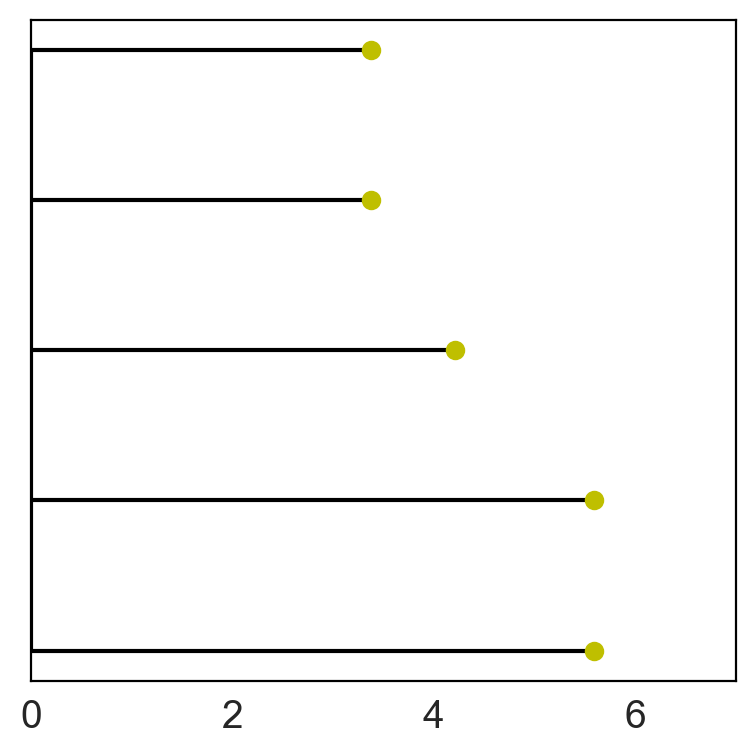

In [47]:
# stem function
enrichr_results =  erichr_res_top[['Term', 'Adjusted P-value']].copy()
enrichr_results['-Log(FDR Pval)'] = np.log(enrichr_results['Adjusted P-value']) * -1

plt.stem(enrichr_results['Term'], enrichr_results['-Log(FDR Pval)'], orientation='horizontal',
        basefmt='k', linefmt='k', markerfmt='y')

# Remove y-axis labels
plt.yticks([])

# Modify x-axis to fit data better
plt.xlim(0, 7)

# Adjust layout to prevent cropping of y-axis labels
plt.tight_layout()

plt.savefig("gH2AX_stemplot_GO_enrichr.pdf")

plt.show()

In [30]:
# Remove NaNs
gammah2ax_df.dropna(inplace=True)
gammah2ax_df

,gene_name,Pearson_r,p_value
0,PINCR,0.363140,0.000000e+00
1,MUC2,0.354819,0.000000e+00
2,FLG-AS1,0.338297,0.000000e+00
3,MDM2,0.330185,0.000000e+00
4,LAMA3,0.290233,0.000000e+00
...,...,...,...
33542,ENSG00000280800,-0.180153,1.291935e-175
33543,DACH1,-0.193293,2.322279e-202
33544,ENSG00000281181,-0.220445,4.320894e-264
33545,ENSG00000278996,-0.223161,9.419850e-271


In [31]:
# generate rank from index
gammah2ax_df = gammah2ax_df.reset_index()
gammah2ax_df = gammah2ax_df.rename(columns={"index": "rank"})

# Display genes with colour
rank_genes = ['PINCR', 'ANXA1', 'CDK1NA', 'PLK2', 'PLK3', 'MDM2', 'POLH']

# Creating a new column 'genes' with True/False values
gammah2ax_df['dna_damage_genes'] = gammah2ax_df['gene_name'].apply(lambda x: any(gene == x for gene in rank_genes))
gammah2ax_df

,rank,gene_name,Pearson_r,p_value,dna_damage_genes
0,0,PINCR,0.363140,0.000000e+00,True
1,1,MUC2,0.354819,0.000000e+00,False
2,2,FLG-AS1,0.338297,0.000000e+00,False
3,3,MDM2,0.330185,0.000000e+00,True
4,4,LAMA3,0.290233,0.000000e+00,False
...,...,...,...,...,...
33542,33542,ENSG00000280800,-0.180153,1.291935e-175,False
33543,33543,DACH1,-0.193293,2.322279e-202,False
33544,33544,ENSG00000281181,-0.220445,4.320894e-264,False
33545,33545,ENSG00000278996,-0.223161,9.419850e-271,False


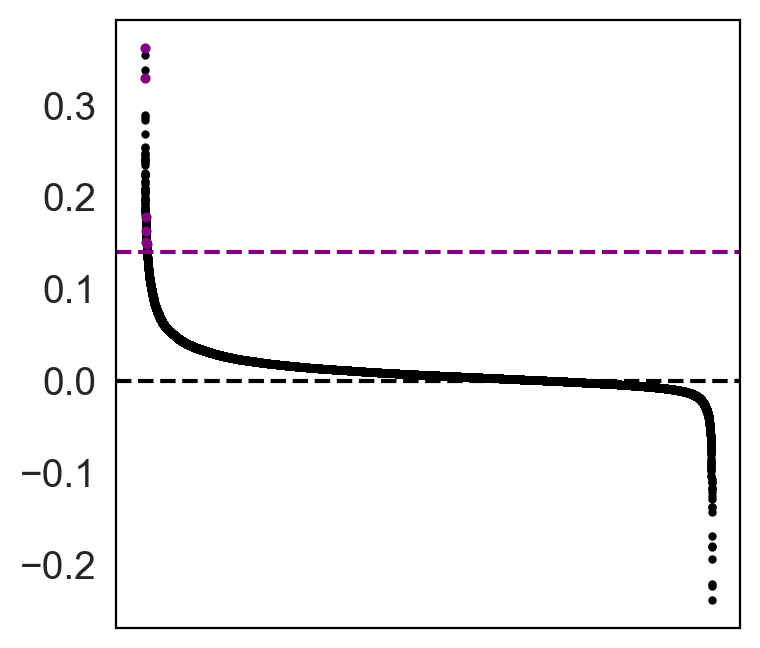

In [32]:
# Plot the correlation
fig, axs = plt.subplots(1, 1)

plot_mask = gammah2ax_df['dna_damage_genes'] == True

# Add an abline horizontal
axs.axhline(y=0.141, color='purple', linestyle='--')
axs.axhline(y=0, color='black', linestyle='--')

axs.scatter(gammah2ax_df.loc[~plot_mask, 'rank'], gammah2ax_df.loc[~plot_mask, 'Pearson_r'], c='black', s=4)
axs.scatter(gammah2ax_df.loc[plot_mask, 'rank'], gammah2ax_df.loc[plot_mask, 'Pearson_r'], c='purple', s=7)

axs.legend([], [], frameon=False)

# Turns off grid on the left Axis.
axs.grid(False)

# Remove x-axis labels
# Remove y-axis labels
plt.xticks([])

plt.savefig("gH2AX_response_rankplot.pdf")

plt.show()

## MELD analysis based on SN38 treatment

In [33]:
# Exctract metadata for meld analysis
# .obs metadata
metadata_pdo21 = ln_rna_data.obs

# Create new slot of SN38 treatment
metadata_pdo21['treatment'] = metadata_pdo21['sample_id'].str.split('_').str[0]

# raw data
data_pdo21_df = ln_mrna_data

In [34]:
# Run Meld
meld_op_pdo21 = meld.MELD()
sample_densities_pdo21 = meld_op_pdo21.fit_transform(data_pdo21_df, sample_labels=metadata_pdo21['treatment'])
sample_densities_pdo21.index = data_pdo21_df.index
data_phate_pdo21 = pdo_rna_adata.obsm['X_phate']

Building graph on 24197 samples and 33740 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 83.48 seconds.
  Calculating KNN search...
  Calculated KNN search in 138.63 seconds.
  Calculating affinities...
  Calculated affinities in 39.26 seconds.
Calculated graph and diffusion operator in 269.54 seconds.


In [35]:
# Add the SN38 perturbed treatment probaility density to metadata
metadata_pdo21['SN38_likelihood'] = meld.utils.normalize_densities(sample_densities_pdo21)['SN38']
pdo_rna_adata.obs['SN38_likelihood'] = metadata_pdo21['SN38_likelihood']

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


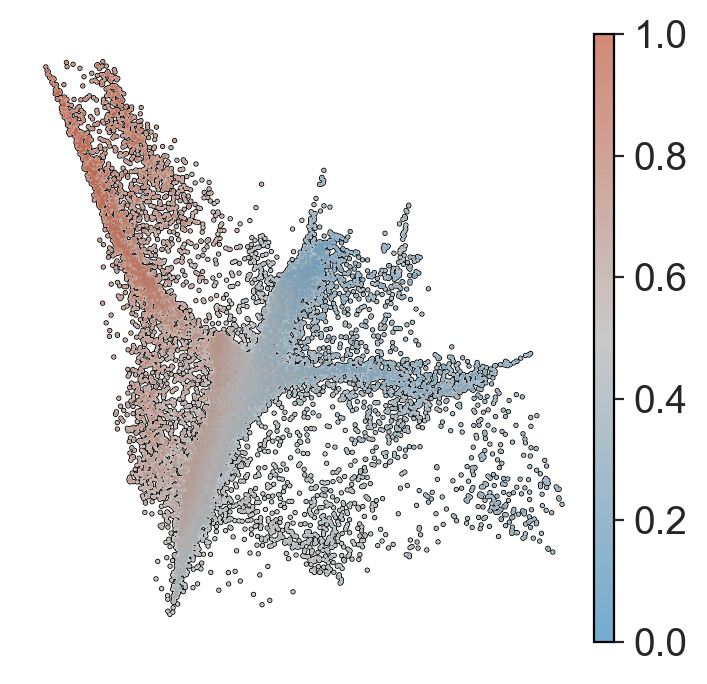

In [36]:
# View the RNA phate with MELD probs
sc.external.pl.phate(pdo_rna_adata, color=['SN38_likelihood'],  
frameon=False, add_outline=True, title='', vmin=0, vmax=1, color_map=meld.get_meld_cmap(), save="_pdo21_meld_phate.pdf")

In [37]:
# Extract means
mean_values = metadata_pdo21.groupby(['sample_id'])['SN38_likelihood'].mean()

# Create a DataFrame from the mean_values array
means_df = pd.DataFrame(mean_values).reset_index()

# Define the desired order of condition_replicate values
order = ['DMSO_PDO', 'SN38_PDO', 'DMSO_PDO_CAF', 'SN38_PDO_CAF']

means_df['sample_id'] = pd.Categorical(means_df['sample_id'], categories=order, ordered=True)
means_df.sort_values(by='sample_id', inplace=True)

# Reset the index of the DataFrame
means_df.reset_index(drop=True, inplace=True)

means_df

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/2968720160.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = metadata_pdo21.groupby(['sample_id'])['SN38_likelihood'].mean()


,sample_id,SN38_likelihood
0,DMSO_PDO,0.325143
1,SN38_PDO,0.654146
2,DMSO_PDO_CAF,0.436610
3,SN38_PDO_CAF,0.558025


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


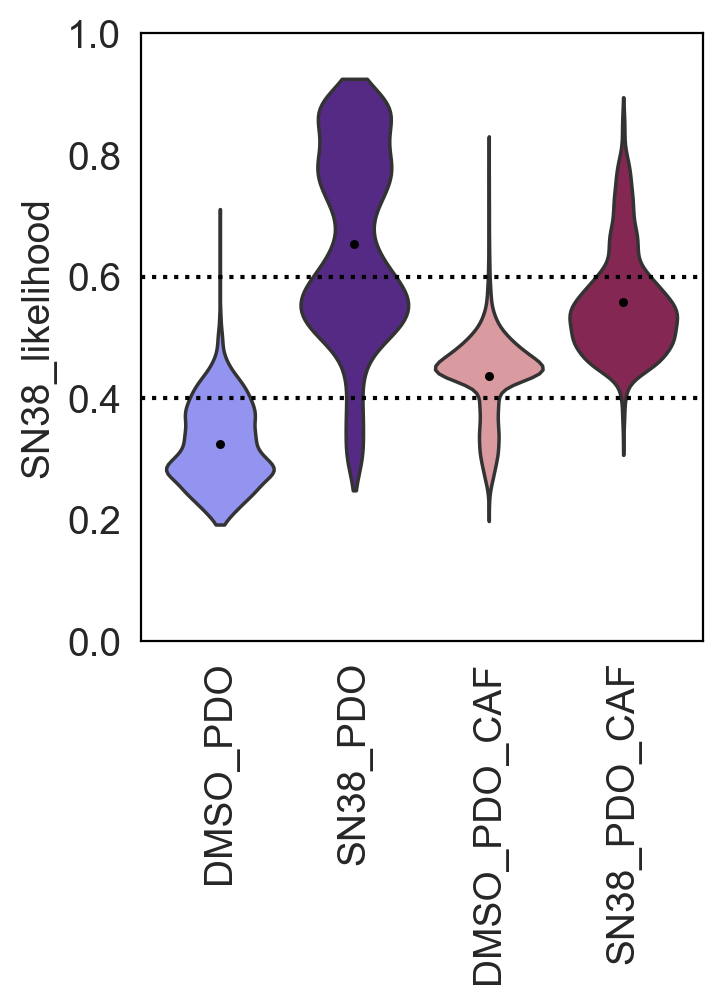

In [38]:
# Plot as a violin plot
ax = sc.pl.violin(pdo_rna_adata, ['SN38_likelihood'],
             stripplot=False, palette=colour_dict_sample, groupby='sample_id', log=False, rotation=90,
             order = vl_order, show=False)

ax.set_ylim(bottom=0,top=1)

# Add mean
plt.scatter(x=range(len(mean_values)), y=means_df['SN38_likelihood'],c="k",s=5)

plt.axhline(y=0.4, color='black', linestyle=':')
plt.axhline(y=0.6, color='black', linestyle=':')


plt.savefig("figures/pdo_analysis/gene_set_analysis/MELD_violin_plot.pdf")

plt.show()

## Gene Signature scoring

In [48]:
# Load proCSC and revCSC gene signatures
gene_signatures = pd.read_csv("data/gene_sigs_hu.csv")
stem_signatures = gene_signatures
gene_signatures.groupby("ANNOTATION").count()

,GENE
ANNOTATION,
proCSC,17
revCSC,25


In [49]:
# Filter based on detected
stem_signatures_filter = stem_signatures[stem_signatures['GENE'].isin(pdo_rna_adata.var_names[pdo_rna_adata.var.n_cells_by_counts>308])]
stem_signatures_filter.groupby("ANNOTATION").count()

,GENE
ANNOTATION,
proCSC,16
revCSC,24


In [62]:
pdo_revCSC = pd.read_csv('data/pdo_revCSC_corr_mono.csv')
pdo_revCSC_signature = pdo_revCSC['gene_name'].to_list()

In [65]:
pdo_proCSC = pd.read_csv('data/pdo_proCSC_corr_mono.csv')
pdo_proCSC_signature = pdo_proCSC['gene_name'].to_list()

In [41]:
# Convert to list format for scoring
proCSC_sig = stem_signatures_filter.loc[stem_signatures_filter["ANNOTATION"]=="proCSC","GENE"].to_list()
revCSC_sig = stem_signatures_filter.loc[stem_signatures_filter["ANNOTATION"]=="revCSC","GENE"].to_list() 

In [67]:
# Score genes for gene signatures
sc.tl.score_genes(pdo_rna_adata, gene_list=proCSC_sig, ctrl_size=25, score_name="proCSC_sig", random_state=12,  use_raw=True)
sc.tl.score_genes(pdo_rna_adata, gene_list=revCSC_sig, ctrl_size=25, score_name="revCSC_sig", random_state=12, use_raw=True)
sc.tl.score_genes(pdo_rna_adata, gene_list=pdo_proCSC_signature, ctrl_size=25, score_name="pdo_proCSC_sig", random_state=12, use_raw=True)
sc.tl.score_genes(pdo_rna_adata, gene_list=pdo_revCSC_signature, ctrl_size=25, score_name="pdo_revCSC_sig", random_state=12, use_raw=True)

computing score 'proCSC_sig'
    finished: added
    'proCSC_sig', score of gene set (adata.obs).
    175 total control genes are used. (0:00:02)
computing score 'revCSC_sig'
    finished: added
    'revCSC_sig', score of gene set (adata.obs).
    248 total control genes are used. (0:00:01)
computing score 'pdo_proCSC_sig'
    finished: added
    'pdo_proCSC_sig', score of gene set (adata.obs).
    310 total control genes are used. (0:00:01)
computing score 'pdo_revCSC_sig'
    finished: added
    'pdo_revCSC_sig', score of gene set (adata.obs).
    147 total control genes are used. (0:00:01)


In [68]:
metadata_pdo21 = pdo_rna_adata.obs

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/2481575434.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = metadata_pdo21.groupby(['sample_id'])['pdo_proCSC_sig'].median()
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


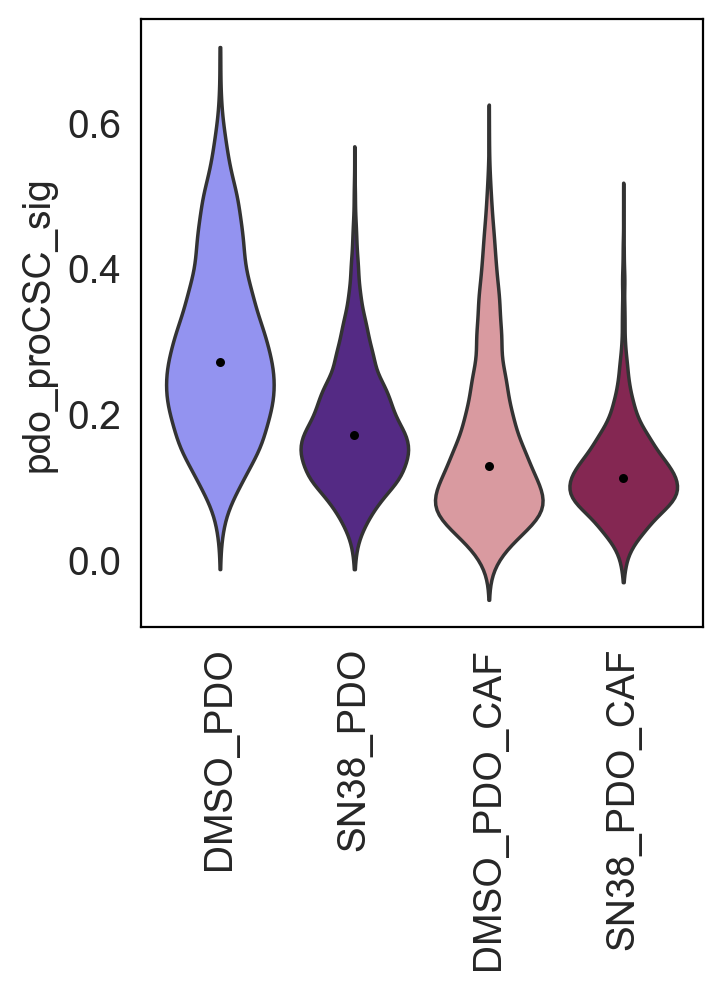

In [69]:
# Extract medians
median_values = metadata_pdo21.groupby(['sample_id'])['pdo_proCSC_sig'].median()

# Create a DataFrame from the median_values array
median_df = pd.DataFrame(median_values).reset_index()

# Define the desired order of condition_replicate values
order = ['DMSO_PDO', 'SN38_PDO', 'DMSO_PDO_CAF', 'SN38_PDO_CAF']

median_df['sample_id'] = pd.Categorical(median_df['sample_id'], categories=order, ordered=True)
median_df.sort_values(by='sample_id', inplace=True)

# Reset the index of the DataFrame
median_df.reset_index(drop=True, inplace=True)

ax = sc.pl.violin(pdo_rna_adata, ['pdo_proCSC_sig'],
             stripplot=False, palette=colour_dict_sample, groupby='sample_id', log=False, rotation=90,
             order = vl_order, show=False)

# Add median 
plt.scatter(x=range(len(median_values)), y=median_df['pdo_proCSC_sig'],c="k",s=5)

plt.savefig("figures/pdo_analysis/gene_set_analysis/pdo_proCSC.pdf")

plt.show()

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_93489/1889723018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = metadata_pdo21.groupby(['sample_id'])['pdo_revCSC_sig'].median()
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


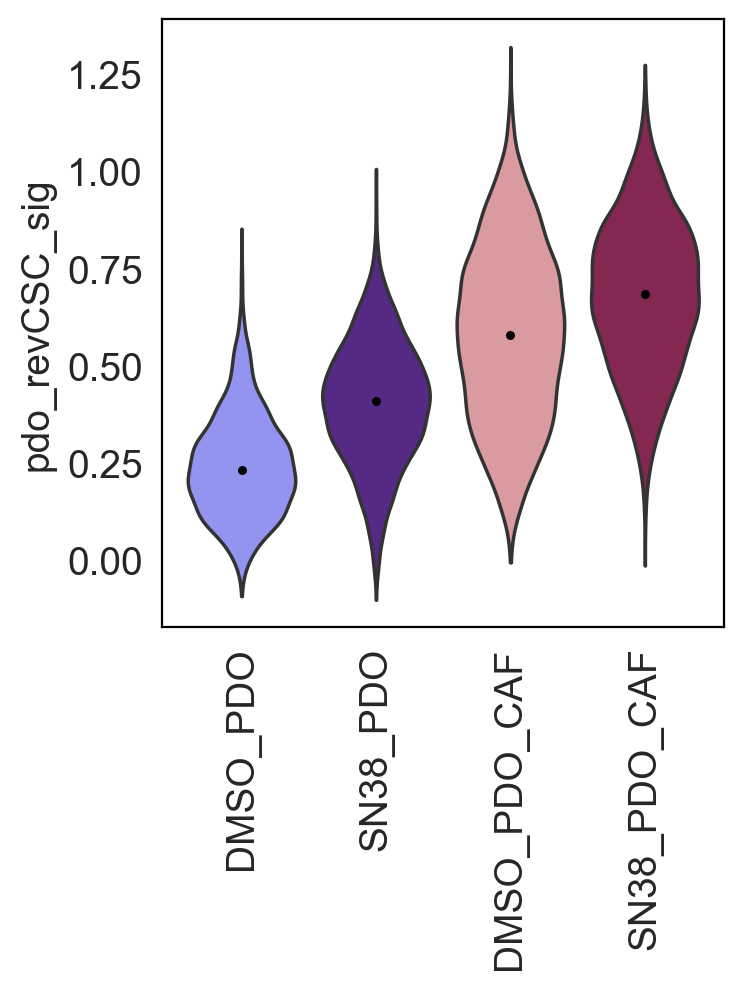

In [72]:
# Extract medians
median_values = metadata_pdo21.groupby(['sample_id'])['pdo_revCSC_sig'].median()

# Create a DataFrame from the median_values array
median_df = pd.DataFrame(median_values).reset_index()

# Define the desired order of condition_replicate values
order = ['DMSO_PDO', 'SN38_PDO', 'DMSO_PDO_CAF', 'SN38_PDO_CAF']

median_df['sample_id'] = pd.Categorical(median_df['sample_id'], categories=order, ordered=True)
median_df.sort_values(by='sample_id', inplace=True)

# Reset the index of the DataFrame
median_df.reset_index(drop=True, inplace=True)

ax = sc.pl.violin(pdo_rna_adata, ['pdo_revCSC_sig'],
             stripplot=False, palette=colour_dict_sample, groupby='sample_id', log=False, rotation=90,
             order = vl_order, show=False)

# Add median
plt.scatter(x=range(len(median_values)), y=median_df['pdo_revCSC_sig'],c="k",s=5)

plt.savefig("figures/pdo_analysis/gene_set_analysis/pdo_revCSC_sig.pdf")

plt.show()

In [78]:
del pdo_rna_adata.layers["scaled"]

In [81]:
# Revert to Log-norm counts for adata size
pdo_rna_adata.X = pdo_rna_adata.raw.X

In [82]:
# Write individually
pdo_rna_adata.write_h5ad('ex0015_epithelial_pdo_rna.h5ad')
pdo_adt_adata.write_h5ad('ex0015_epithelial_pdo_adt.h5ad')